# ModelConductor demo

This short tutorial will cover the basic workflow of conducting One-To-One experiments with ModelConductor. The experiment has two distinct parts, i.e. 

1) The process of writing high-frequency process data to an SQLite database is simulated with a mockup function and

2) The database is concurrently polled and the latest database streamed to a dynamical simulation model, distributed as an Functional Mockup Unit (FMU). The model's output is saved to a csv file

The FMU Model is implemented originally in MapleSim and taken from https://github.com/modelica/fmi-cross-check/tree/master/fmus/2.0/cs/win64/MapleSim/2018/CoupledClutches

The input file to the FMU has been trimmed down to first 1.4 seconds (approx. 1400 samples)

For a more detail description of the various ModelConductor components, read the code or see the original publication in [1]

[1] Aho, P. 2019. An Open Source Digital Twin Framework. Master's Thesis. Tampere University

# Preliminaries

Let us examine what we have, i.e., the FMU model and input data. 

In [1]:
from fmpy import dump

In [2]:
dump('CoupledClutches.fmu')


Model Info

  FMI Version       2.0
  FMI Type          Co-Simulation
  Model Name        CoupledClutches
  Description       Model CoupledClutches
  Platforms         win64
  Continuous States 8
  Event Indicators  25
  Variables         148
  Generation Tool   MapleSim (1357016/1357197/1357197)
  Generation Date   2018-10-25T13:27:07Z

Default Experiment

  Stop Time         1.5
  Step Size         0.01

Variables (input, output)

Name                Causality              Start Value  Unit     Description
inputs              input      0.00000000000000000e+00           RI1
outputs[1]          output     1.00000000000000000e+01  rad/s    J1.w
outputs[2]          output     0.00000000000000000e+00  rad/s    J2.w
outputs[3]          output     0.00000000000000000e+00  rad/s    J3.w
outputs[4]          output     0.00000000000000000e+00  rad/s    J4.w


In [3]:
from matplotlib import pyplot as plt

## The data source

Periodical database writes of the mock input data are made, approximating the process of data acquisition from real-world sensory measuremnens

In [4]:
import sqlalchemy as sqla
import pandas as pd
from datetime import datetime as dt
from time import sleep

## Receive loop

Using an appropriate ModelConductor component the database is periodically polled for new data. Herein a data point is naively considered new if it has an integer primary key that is previously unseen by the poller

In [5]:
from modelconductor.measurementhandler import IncomingMeasurementListener

The polling interval should, typically, be set slightly higher than the write interval

In [6]:
source = IncomingMeasurementListener()

## Model loop

The FMU model is wrapped with a corresponding ModelConductor component, thereafter operating on a 'pull' manner. Whenever a previously unseen datapoint is identified as a result of database poll operation, it is relayed to the corresponding ModelHandler component  

In [7]:
from modelconductor.modelhandler import FMUModelHandler

Within ModelConductor, all data that is to be exchanged from one data source / data consumer to another, is asserted to exists in one of two possible formats: 

i) A Measurement object that denotes a timestamped data structure that is received from a physical asset, best understood as a snapshot of the asset’s state at a given time or

ii) a ModelResponse object that similarly denotes a timestamped data structure that is received from a digital asset, a snapshot of the model’s virtual state at a given time 

A variable (a key) may, but is not required to belong to one or more of the following categories:

1) Input keys: The subset of keys in Measurement object corresponding to the keys that are expected as  inputs by the relevant ModelHandler

2) Target keys: The keys that are expected to be output from a ModelHandler instance onto a ModelResponse object

3) Control keys: A subset of keys in Measurement that is not intended to be used as an input to a ModelHandler, but rather as a validation variable against the ModelHandler output

4) Timestamp key: A key denoting the instant when the relevant Measurement or ModelResponce instance was created.


In [8]:
target_keys = ["outputs[1]",
               "outputs[2]",
               "outputs[3]",
               "outputs[4]"]
input_keys = ["inputs"]
control_keys = ["time", "TIMING_client_request_timestamp", 
                "TIMING_model_response_timestamp"]
timestamp_key = "time"

Now the ModelHandler object can be instantiated:

In [9]:
model=FMUModelHandler(
    fmu_path='CoupledClutches.fmu',
    start_time=0,
    stop_time=1.5,
    step_size=0.01,
    target_keys=target_keys,
    input_keys=input_keys,
    control_keys=control_keys,
    timestamp_key=timestamp_key)

## The experiment
The Receive and Model loops are tied together within the experiment component

In [10]:
from modelconductor.experiment import OnlineOneToOneExperiment

In [11]:
ex = OnlineOneToOneExperiment(logging=True, runtime=3, log_path='out.csv')
ex.add_route((source, model))
ex.setup()

0

## Run
Start the experiment

In [12]:
# Start the experiment
ex.run()

[OK] [%s]: GUID = %s
[OK] fmi2EnterInitializationMode
Waiting for connection...
127.0.0.1:59655 has connected.
Received message:  b'{"time":0.0,"inputs":0.0,"TIMING_client_request_ti'
Current buffer: stepping: 1

[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 9.900000031706817, 'outputs[2]': 0.09999996829318347, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0, 'TIMING_client_request_timestamp': 1612467429.4018242, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 9.900000031706817, 'outputs[2]': 0.09999996829318347, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0, 'TIMING_client_request_timestamp': 1612467429.4018242, 

Received message:  b'{"time":0.0099999998,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 9.338308597170043, 'outputs[2]': 1.0998416454412034, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0099999998, 'TIMING_client_request_timestamp': 1612467430.5609505, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 9.338308597170043, 'outputs[2]': 1.0998416454412034, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0099999998, 'TIMING_client_request_timestamp': 1612467430.5609505, 'TIMING_model_response_timestamp': 1612467431.0922832}
Received message:  b'{"time":0.010999999

Received message:  b'{"time":0.0199999996,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g 1

[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 9.031847814241853, 'outputs[2]': 2.099385429678063, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0199999996, 'TIMING_client_request_timestamp': 1612467432.1958423, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 9.031847814241853, 'outputs[2]': 2.099385429678063, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0199999996, 'TIMING_client_request_timestamp': 1612467432.1958423, 'TIMING_model_response_timestamp': 1612467432.2239108}
Received message:  b'{"time":0.0209999997,

Received message:  b'{"time":0.0299999993,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 8.912931729477549, 'outputs[2]': 3.098473481448555, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0299999993, 'TIMING_client_request_timestamp': 1612467433.343356, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 8.912931729477549, 'outputs[2]': 3.098473481448555, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0299999993, 'TIMING_client_request_timestamp': 1612467433.343356, 'TIMING_model_response_timestamp': 1612467433.3672264}
Received message:  b'{"time":0.0309999995,"i

Received message:  b'{"time":0.0399999991,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 8.895560745283502, 'outputs[2]': 4.096948033175338, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0399999991, 'TIMING_client_request_timestamp': 1612467434.483812, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 8.895560745283502, 'outputs[2]': 4.096948033175338, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0399999991, 'TIMING_client_request_timestamp': 1612467434.483812, 'TIMING_model_response_timestamp': 1612467434.5645516}
Received message:  b'{"time":0.0410000011,"i

Received message:  b'{"time":0.0500000007,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 [OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 8.883855280409843, 'outputs[2]': 5.094651414151982, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0500000007, 'TIMING_client_request_timestamp': 1612467435.6201065, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 8.883855280409843, 'outputs[2]': 5.094651414151982, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0500000007, 'TIMING_client_request_timestamp': 1612467435.6201065, 'TIMING_model_response_timestamp': 1612467435.6908655}
Received message:  b'{"time":0.050999999,"

Received message:  b'{"time":0.0599999987,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 8.781456535159583, 'outputs[2]': 6.091426075431008, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0599999987, 'TIMING_client_request_timestamp': 1612467436.757663, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 8.781456535159583, 'outputs[2]': 6.091426075431008, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0599999987, 'TIMING_client_request_timestamp': 1612467436.757663, 'TIMING_model_response_timestamp': 1612467436.79551}
Received message:  b'{"time":0.0610000007,"inp

Received message:  b'{"time":0.0700000003,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
 [OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g1
Got response from model {'inputs': 0.0, 'outputs[1]': 8.50097416213343, 'outputs[2]': 7.087114614730006, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0700000003, 'TIMING_client_request_timestamp': 1612467437.8904657, 'TIMING_model_response_timestamp': 0}
Got response from model:  
{'inputs': 0.0, 'outputs[1]': 8.50097416213343, 'outputs[2]': 7.087114614730006, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0700000003, 'TIMING_client_request_timestamp': 1612467437.8904657, 'TIMING_model_response_timestamp': 1612467437.9283078}
Received message:  b'{"time":0.0710000023,"i

Received message:  b'{"time":0.0799999982,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.972556028533292, 'outputs[2]': 8.081559801283635, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0799999982, 'TIMING_client_request_timestamp': 1612467439.0323493, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 7.972556028533292, 'outputs[2]': 8.081559801283635, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0799999982, 'TIMING_client_request_timestamp': 1

Received message:  b'{"time":0.0890000015,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping: 1

[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 8.056600486552485, 'outputs[2]': 8.165604259302828, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0890000015, 'TIMING_client_request_timestamp': 1612467440.2667565, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 8.056600486552485, 'outputs[2]': 8.165604259302828, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0890000015, 'TIMING_client_request_timestamp': 1612467440.2667565, 'TIMING_model_response_timestamp': 1612467440.309579}
Received message:  b'{"time":0.0900000036,"

Received message:  b'{"time":0.0979999974,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping: 1

[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 8.01439092441162, 'outputs[2]': 8.123394697161963, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0979999974, 'TIMING_client_request_timestamp': 1612467441.7387648, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 8.01439092441162, 'outputs[2]': 8.123394697161963, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0979999974, 'TIMING_client_request_timestamp': 1612467441.7387648, 'TIMING_model_response_timestamp': 1612467441.821498}
Received message:  b'{"time":0.0989999995,"in

Received message:  b'{"time":0.1080000028,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.823827265065431, 'outputs[2]': 7.932831037815777, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1080000028, 'TIMING_client_request_timestamp': 1612467442.8822656, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 7.823827265065431, 'outputs[2]': 7.932831037815777, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1080000028, 'TIMING_client_request_timestamp': 1612467442.8822656, 'TIMING_model_response_timestamp': 1612467442.9131625}
Received message:  b'{"time":0.1089999974,

Received message:  b'{"time":0.1180000007,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
 1
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.500423668426041, 'outputs[2]': 7.609427441176388, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1180000007, 'TIMING_client_request_timestamp': 1612467444.0188487, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 7.500423668426041, 'outputs[2]': 7.609427441176388, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1180000007, 'TIMING_client_request_timestamp': 1612467444.0188487, 'TIMING_model_response_timestamp': 1612467444.0525625}
Received message:  b'{"time":0.1190000027,

Received message:  b'{"time":0.1280000061,"inputs":0.0,"TIMING_client_r'
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16gCurrent buffer: 
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s 0

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.075837129023322, 'outputs[2]': 7.1848409017736685, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1280000061, 'TIMING_client_request_timestamp': 1612467445.1414776, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 7.075837129023322, 'outputs[2]': 7.1848409017736685, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1280000061, 'TIMING_client_request_timestamp': 1612467445.1414776, 'TIMING_model_response_timestamp': 1612467445.2122838}
Received message:  b'{"time":0.128999993

Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 6.591629147657151, 'outputs[2]': 6.7006329204074975, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1379999965, 'TIMING_client_request_timestamp': 1612467446.2610576, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 6.591629147657151, 'outputs[2]': 6.7006329204074975, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1379999965, 'TIMING_client_request_timestamp': 1612467446.2610576, 'TIMING_model_response_timestamp': 1612467446.3149607}
Received message:  b'{"time":0.1389999986,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi

Received message:  b'{"time":0.1480000019,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
 [OK] fmi2SetReal: nvr = %d1
[OK] fmi2SetReal: #r%d# = %.16g

[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 6.095197366900407, 'outputs[2]': 6.2042011396507535, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1480000019, 'TIMING_client_request_timestamp': 1612467447.3827388, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 6.095197366900407, 'outputs[2]': 6.2042011396507535, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1480000019, 'TIMING_client_request_timestamp': 1612467447.3827388, 'TIMING_model_response_timestamp': 1612467447.473055}
Received message:  b'{"time":0.1490000039

Received message:  b'{"time":0.1580000073,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.635135994483928, 'outputs[2]': 5.744139767234275, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1580000073, 'TIMING_client_request_timestamp': 1612467448.5000908, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.635135994483928, 'outputs[2]': 5.744139767234275, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1580000073, 'TIMING_client_request_timestamp': 1612467448.5000908, 'TIMING_model_response_timestamp': 1612467448.5330043}
Received message:  b'{"time":0.1589999944,

Received message:  b'{"time":0.1679999977,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.256479033962828, 'outputs[2]': 5.365482806713175, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1679999977, 'TIMING_client_request_timestamp': 1612467449.6470602, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.256479033962828, 'outputs[2]': 5.365482806713175, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1679999977, 'TIMING_client_request_timestamp': 1612467449.6470602, 'TIMING_model_response_timestamp': 1612467449.7218578}
Received message:  b'{"time":0.1689999998,

Received message:  b'{"time":0.1780000031,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.996292063450529, 'outputs[2]': 5.105295836200876, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1780000031, 'TIMING_client_request_timestamp': 1612467451.1928356, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.996292063450529, 'outputs[2]': 5.105295836200876, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1780000031, 'TIMING_client_request_timestamp': 1612467451.1928356, 'TIMING_model_response_timestamp': 1612467451.2347248}
Received message:  b'{"time":0.1790000051,

Received message:  b'{"time":0.1879999936,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping: 1

[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.88004403922373, 'outputs[2]': 4.989047811974077, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1879999936, 'TIMING_client_request_timestamp': 1612467452.336924, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.88004403922373, 'outputs[2]': 4.989047811974077, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1879999936, 'TIMING_client_request_timestamp': 1612467452.336924, 'TIMING_model_response_timestamp': 1612467452.400752}
Received message:  b'{"time":0.1889999956,"inpu

Received message:  b'{"time":0.1979999989,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
 1
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.919114039822045, 'outputs[2]': 5.0281178125723915, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1979999989, 'TIMING_client_request_timestamp': 1612467453.5023494, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.919114039822045, 'outputs[2]': 5.0281178125723915, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1979999989, 'TIMING_client_request_timestamp': 1612467453.5023494, 'TIMING_model_response_timestamp': 1612467453.5491543}
Received message:  b'{"time":0.199000001

Received message:  b'{"time":0.2080000043,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.109677710470243, 'outputs[2]': 5.21868148322059, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2080000043, 'TIMING_client_request_timestamp': 1612467454.639065, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.109677710470243, 'outputs[2]': 5.21868148322059, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2080000043, 'TIMING_client_request_timestamp': 1612467454.639065, 'TIMING_model_response_timestamp': 1612467454.6629372}
Received message:  b'{"time":0.2090000063,"inp

Received message:  b'{"time":0.2179999948,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 [OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.433081306825933, 'outputs[2]': 5.54208507957628, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2179999948, 'TIMING_client_request_timestamp': 1612467455.7636893, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.433081306825933, 'outputs[2]': 5.54208507957628, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2179999948, 'TIMING_client_request_timestamp': 1612467455.7636893, 'TIMING_model_response_timestamp': 1612467455.8194792}
1
Received message:  b'{"time":0.2189999968,"i

Received message:  b'{"time":0.2280000001,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping: 1

[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.8576678345793605, 'outputs[2]': 5.966671607329707, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2280000001, 'TIMING_client_request_timestamp': 1612467456.881692, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.8576678345793605, 'outputs[2]': 5.966671607329707, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2280000001, 'TIMING_client_request_timestamp': 1612467456.881692, 'TIMING_model_response_timestamp': 1612467456.9265704}
Received message:  b'{"time":0.2290000021,

Received message:  b'{"time":0.2380000055,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 6.341875818053271, 'outputs[2]': 6.450879590803618, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2380000055, 'TIMING_client_request_timestamp': 1612467458.0094693, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 6.341875818053271, 'outputs[2]': 6.450879590803618, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2380000055, 'TIMING_client_request_timestamp': 1612467458.0094693, 'TIMING_model_response_timestamp': 1612467458.035398}
Received message:  b'{"time":0.2389999926,"

Received message:  b'{"time":0.2479999959,"inputs":0.0,"TIMING_client_r'
Current buffer:  stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
1[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 6.838307596634266, 'outputs[2]': 6.947311369384613, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2479999959, 'TIMING_client_request_timestamp': 1612467459.1280982, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 6.838307596634266, 'outputs[2]': 6.947311369384613, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2479999959, 'TIMING_client_request_timestamp': 1612467459.1280982, 'TIMING_model_response_timestamp': 1612467459.20284}
Received message:  b'{"time":0.248999998,"in

Received message:  b'{"time":0.2579999864,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
 1
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.298368974794882, 'outputs[2]': 7.407372747545229, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2579999864, 'TIMING_client_request_timestamp': 1612467460.2459216, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 7.298368974794882, 'outputs[2]': 7.407372747545229, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2579999864, 'TIMING_client_request_timestamp': 1612467460.2459216, 'TIMING_model_response_timestamp': 1612467460.3186672}
Received message:  b'{"time":0.2590000033,

Received message:  b'{"time":0.2680000067,"inputs":0.0,"TIMING_client_r'
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
Current buffer:  [OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g0
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.677025965127127, 'outputs[2]': 7.786029737877474, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2680000067, 'TIMING_client_request_timestamp': 1612467461.3590813, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 7.677025965127127, 'outputs[2]': 7.786029737877474, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2680000067, 'TIMING_client_request_timestamp': 1612467461.3590813, 'TIMING_model_response_timestamp': 1612467461.400962}

Received message:  b'{"time":0.2689999938,"

Received message:  b'{"time":0.2779999971,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.937212895796994, 'outputs[2]': 8.046216668547341, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2779999971, 'TIMING_client_request_timestamp': 1612467462.4755437, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 7.937212895796994, 'outputs[2]': 8.046216668547341, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2779999971, 'TIMING_client_request_timestamp': 1612467462.4755437, 'TIMING_model_response_timestamp': 1612467462.528165}
Received message:  b'{"time":0.2790000141,"

Received message:  b'{"time":0.2879999876,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model  {'inputs': 0.0, 'outputs[1]': 8.053460919780173, 'outputs[2]': 8.162464692530522, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2879999876, 'TIMING_client_request_timestamp': 1612467463.5857108, 'TIMING_model_response_timestamp': 0}
Got response from model:  1{'inputs': 0.0, 'outputs[1]': 8.053460919780173, 'outputs[2]': 8.162464692530522, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2879999876, 'TIMING_client_request_timestamp': 1612467463.5857108, 'TIMING_model_response_timestamp': 1612467463.6216192}

Received message:  b'{"time":0.2890000045,

Received message:  b'{"time":0.2980000079,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 8.014390919054048, 'outputs[2]': 8.123394691804396, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2980000079, 'TIMING_client_request_timestamp': 1612467464.7069674, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 8.014390919054048, 'outputs[2]': 8.123394691804396, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2980000079, 'TIMING_client_request_timestamp': 1612467464.7069674, 'TIMING_model_response_timestamp': 1612467464.7637556}
Received message:  b'{"time":0.298999995,"

Received message:  b'{"time":0.3079999983,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.823827248902602, 'outputs[2]': 7.932831021652949, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3079999983, 'TIMING_client_request_timestamp': 1612467465.836953, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 7.823827248902602, 'outputs[2]': 7.932831021652949, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3079999983, 'TIMING_client_request_timestamp': 1612467465.836953, 'TIMING_model_response_timestamp': 1612467465.8718724}
Received message:  b'{"time":0.3089999855,"i

Received message:  b'{"time":0.3179999888,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g 1

[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.500423657156822, 'outputs[2]': 7.609427429907169, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3179999888, 'TIMING_client_request_timestamp': 1612467467.980342, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 7.500423657156822, 'outputs[2]': 7.609427429907169, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3179999888, 'TIMING_client_request_timestamp': 1612467467.980342, 'TIMING_model_response_timestamp': 1612467468.0292017}
Received message:  b'{"time":0.3190000057,"i

Received message:  b'{"time":0.3269999921,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping: 
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.121724855188244, 'outputs[2]': 7.230728627938591, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3269999921, 'TIMING_client_request_timestamp': 1612467468.988055, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 7.121724855188244, 'outputs[2]': 7.230728627938591, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3269999921, 'TIMING_client_request_timestamp': 1612467468.988055, 'TIMING_model_response_timestamp': 1612467469.032749}
Received message:  b'{"time":0.3280000091,"in

Received message:  b'{"time":0.3370000124,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
 1[0.0]
[OK] fmi2SetReal: nvr = %d

[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 6.641407240346171, 'outputs[2]': 6.750411013096517, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3370000124, 'TIMING_client_request_timestamp': 1612467470.1093068, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 6.641407240346171, 'outputs[2]': 6.750411013096517, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3370000124, 'TIMING_client_request_timestamp': 1612467470.1093068, 'TIMING_model_response_timestamp': 1612467470.1990733}
Received message:  b'{"time":0.3379999995,

Received message:  b'{"time":0.3470000029,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 6.143993196632431, 'outputs[2]': 6.252996969382778, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3470000029, 'TIMING_client_request_timestamp': 1612467471.2503877, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 6.143993196632431, 'outputs[2]': 6.252996969382778, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3470000029, 'TIMING_client_request_timestamp': 1612467471.2503877, 'TIMING_model_response_timestamp': 1612467471.2872865}
Received message:  b'{"time":0.34799999,"i

stepping:
Current buffer: [0.0]
 0[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.678173074705274, 'outputs[2]': 5.787176847455621, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3569999933, 'TIMING_client_request_timestamp': 1612467472.3998919, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.678173074705274, 'outputs[2]': 5.787176847455621, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3569999933, 'TIMING_client_request_timestamp': 1612467472.3998919, 'TIMING_model_response_timestamp': 1612467472.4666617}
Received message:  b'{"time":0.3580000103,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fm

Received message:  b'{"time":0.3670000136,"inputs":0.0,"TIMING_client_r'
Current buffer:  1stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.289544615363801, 'outputs[2]': 5.398548388114148, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3670000136, 'TIMING_client_request_timestamp': 1612467473.5362182, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.289544615363801, 'outputs[2]': 5.398548388114148, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3670000136, 'TIMING_client_request_timestamp': 1612467473.5362182, 'TIMING_model_response_timestamp': 1612467473.5651383}
Received message:  b'{"time":0.3680000007,

Received message:  b'{"time":0.3770000041,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 [OK] fmi2GetReal: #r%u# = %.16g1

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.016149457469298, 'outputs[2]': 5.125153230219645, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3770000041, 'TIMING_client_request_timestamp': 1612467474.6700325, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.016149457469298, 'outputs[2]': 5.125153230219645, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3770000041, 'TIMING_client_request_timestamp': 1612467474.6700325, 'TIMING_model_response_timestamp': 1612467474.7298696}
Received message:  b'{"time":0.3779999912,

Received message:  b'{"time":0.3869999945,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
 1
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.884749423416143, 'outputs[2]': 4.99375319616649, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3869999945, 'TIMING_client_request_timestamp': 1612467475.7972124, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.884749423416143, 'outputs[2]': 4.99375319616649, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3869999945, 'TIMING_client_request_timestamp': 1612467475.7972124, 'TIMING_model_response_timestamp': 1612467475.8450267}
Received message:  b'{"time":0.3880000114,"i

Received message:  b'{"time":0.3970000148,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
 1
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.608206860796556, 'outputs[2]': 4.717210633546903, 'outputs[3]': 0.6, 'outputs[4]': 0.0, 'time': 0.3970000148, 'TIMING_client_request_timestamp': 1612467476.92372, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.608206860796556, 'outputs[2]': 4.717210633546903, 'outputs[3]': 0.6, 'outputs[4]': 0.0, 'time': 0.3970000148, 'TIMING_client_request_timestamp': 1612467476.92372, 'TIMING_model_response_timestamp': 1612467476.9855003}
Received message:  b'{"time":0.3980000019,"inp

Received message:  b'{"time":0.4059999883,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 [OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g1

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.275588828566836, 'outputs[2]': 4.384592601317183, 'outputs[3]': 1.6000000000000003, 'outputs[4]': 0.0, 'time': 0.4059999883, 'TIMING_client_request_timestamp': 1612467478.0477836, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.275588828566836, 'outputs[2]': 4.384592601317183, 'outputs[3]': 1.6000000000000003, 'outputs[4]': 0.0, 'time': 0.4059999883, 'TIMING_client_request_timestamp': 1612467478.0477836, 'TIMING_model_response_timestamp': 1612467478.0956085}
Received mes

Received message:  b'{"time":0.4160000086,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 1[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.074578181021167, 'outputs[2]': 4.1835819537715135, 'outputs[3]': 2.600000000000001, 'outputs[4]': 0.0, 'time': 0.4160000086, 'TIMING_client_request_timestamp': 1612467479.1664562, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.074578181021167, 'outputs[2]': 4.1835819537715135, 'outputs[3]': 2.600000000000001, 'outputs[4]': 0.0, 'time': 0.4160000086, 'TIMING_client_request_timestamp': 1612467479.1664562, 'TIMING_m

Received message:  b'{"time":0.4250000119,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
 [OK] fmi2GetReal: #r%u# = %.16g1
[OK] fmi2GetReal: #r%u# = %.16g

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.987439292029215, 'outputs[2]': 4.096443064779562, 'outputs[3]': 3.5000000000000018, 'outputs[4]': 0.0, 'time': 0.4250000119, 'TIMING_client_request_timestamp': 1612467480.1704216, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.987439292029215, 'outputs[2]': 4.096443064779562, 'outputs[3]': 3.5000000000000018, 'outputs[4]': 0.0, 'time': 0.4250000119, 'TIMING_client_request_timestamp': 1612467480.1704216, 'TIMING_m

Received message:  b'{"time":0.4329999983,"inputs":0.0,"TIMING_client_r'
Current buffer:  stepping:
1[0.0]

[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.072377288987098, 'outputs[2]': 4.083099211272515, 'outputs[3]': 4.174823740894599, 'outputs[4]': 0.0, 'time': 0.4329999983, 'TIMING_client_request_timestamp': 1612467481.061312, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.072377288987098, 'outputs[2]': 4.083099211272515, 'outputs[3]': 4.174823740894599, 'outputs[4]': 0.0, 'time': 0.4329999983, 'TIMING_client_request_timestamp': 1612467481.061312, 'TIMING_model_response_timestamp': 1612467481.1280804}
Received message

Received message:  b'{"time":0.4429999888,"inputs":0.0,"TIMING_client_r'
Current buffer:  stepping:
[0.0]
1
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.403331804627335, 'outputs[2]': 4.414053726912752, 'outputs[3]': 4.505778256534836, 'outputs[4]': 0.0, 'time': 0.4429999888, 'TIMING_client_request_timestamp': 1612467482.1914177, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.403331804627335, 'outputs[2]': 4.414053726912752, 'outputs[3]': 4.505778256534836, 'outputs[4]': 0.0, 'time': 0.4429999888, 'TIMING_client_request_timestamp': 1612467482.1914177, 'TIMING_model_response_timestamp': 1612467482.238238}
Received messag

Received message:  b'{"time":0.4530000091,"inputs":0.0,"TIMING_client_r'
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
Current buffer: [OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 0
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.726137127421672, 'outputs[2]': 4.736859049707089, 'outputs[3]': 4.828583579329173, 'outputs[4]': 0.0, 'time': 0.4530000091, 'TIMING_client_request_timestamp': 1612467483.3096044, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.726137127421672, 'outputs[2]': 4.736859049707089, 'outputs[3]': 4.828583579329173, 'outputs[4]': 0.0, 'time': 0.4530000091, 'TIMING_client_request_timestamp': 1612467483.3096044, 'TIMING_model_response_timestamp': 1612467483.3534367}
Received messa

Received message:  b'{"time":0.4629999995,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.009194806493647, 'outputs[2]': 5.019916728779064, 'outputs[3]': 5.111641258401148, 'outputs[4]': 0.0, 'time': 0.4629999995, 'TIMING_client_request_timestamp': 1612467484.4335465, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.009194806493647, 'outputs[2]': 5.019916728779064, 'outputs[3]': 5.111641258401148, 'outputs[4]': 0.0, 'time': 0.4629999995, 'TIMING_client_request_timestamp': 1612467484.4335465, 'TIMING_model_response_timestamp': 1612467484.476437}
Received messag

Received message:  b'{"time":0.47299999,"inputs":0.0,"TIMING_client_req'
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
Current buffer: [OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
 0
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.224797217356111, 'outputs[2]': 5.235519139641528, 'outputs[3]': 5.327243669263612, 'outputs[4]': 0.0, 'time': 0.47299999, 'TIMING_client_request_timestamp': 1612467485.5491226, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.224797217356111, 'outputs[2]': 5.235519139641528, 'outputs[3]': 5.327243669263612, 'outputs[4]': 0.0, 'time': 0.47299999, 'TIMING_client_request_timestamp': 1612467485.5491226, 'TIMING_model_response_timestamp': 1612467485.6138978}
Received message: 

Received message:  b'{"time":0.4830000103,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 [OK] fmi2GetReal: #r%u# = %.16g
1[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.351839681674723, 'outputs[2]': 5.36256160396014, 'outputs[3]': 5.454286133582224, 'outputs[4]': 0.0, 'time': 0.4830000103, 'TIMING_client_request_timestamp': 1612467486.6671329, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.351839681674723, 'outputs[2]': 5.36256160396014, 'outputs[3]': 5.454286133582224, 'outputs[4]': 0.0, 'time': 0.4830000103, 'TIMING_client_request_timestamp': 1612467486.6671329, 'TIMING_model_response_timestamp': 1612467486.7199428}

Received message

Received message:  b'{"time":0.4930000007,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
 1
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.377886336348782, 'outputs[2]': 5.388608258634199, 'outputs[3]': 5.480332788256283, 'outputs[4]': 0.0, 'time': 0.4930000007, 'TIMING_client_request_timestamp': 1612467487.7855155, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.377886336348782, 'outputs[2]': 5.388608258634199, 'outputs[3]': 5.480332788256283, 'outputs[4]': 0.0, 'time': 0.4930000007, 'TIMING_client_request_timestamp': 1612467487.7855155, 'TIMING_model_response_timestamp': 1612467487.8712957}
Received messa

Received message:  b'{"time":0.503000021,"inputs":0.0,"TIMING_client_re'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
 [OK] fmi2GetReal: #r%u# = %.16g
1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.3003876706403465, 'outputs[2]': 5.311109592925764, 'outputs[3]': 5.402834122547848, 'outputs[4]': 0.0, 'time': 0.503000021, 'TIMING_client_request_timestamp': 1612467488.9011781, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.3003876706403465, 'outputs[2]': 5.311109592925764, 'outputs[3]': 5.402834122547848, 'outputs[4]': 0.0, 'time': 0.503000021, 'TIMING_client_request_timestamp': 1612467488.9011781, 'TIMING_model_response_timestamp': 1612467488.9251072}
Received messa

Received message:  b'{"time":0.5130000114,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping: 1
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.126929652299696, 'outputs[2]': 5.137651574585113, 'outputs[3]': 5.229376104207197, 'outputs[4]': 0.0, 'time': 0.5130000114, 'TIMING_client_request_timestamp': 1612467490.018432, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.126929652299696, 'outputs[2]': 5.137651574585113, 'outputs[3]': 5.229376104207197, 'outputs[4]': 0.0, 'time': 0.5130000114, 'TIMING_client_request_timestamp': 1612467490.018432, 'TIMING_model_response_timestamp': 1612467490.0613248}
Received message

stepping:Current buffer:  0

[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.874491674288898, 'outputs[2]': 4.885213596574316, 'outputs[3]': 4.9769381261964005, 'outputs[4]': 0.0, 'time': 0.5230000019, 'TIMING_client_request_timestamp': 1612467491.1314788, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.874491674288898, 'outputs[2]': 4.885213596574316, 'outputs[3]': 4.9769381261964005, 'outputs[4]': 0.0, 'time': 0.5230000019, 'TIMING_client_request_timestamp': 1612467491.1314788, 'TIMING_model_response_timestamp': 1612467491.202404}
Received message:  b'{"time":0.523999989,"inputs":0.0,"TIMING_client_re'
Current buffe

Received message:  b'{"time":0.5329999924,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping: 1

[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.5677841008265405, 'outputs[2]': 4.5785060231119585, 'outputs[3]': 4.670230552734043, 'outputs[4]': 0.0, 'time': 0.5329999924, 'TIMING_client_request_timestamp': 1612467492.2553413, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.5677841008265405, 'outputs[2]': 4.5785060231119585, 'outputs[3]': 4.670230552734043, 'outputs[4]': 0.0, 'time': 0.5329999924, 'TIMING_client_request_timestamp': 1612467492.2553413, 'TIMING_model_response_timestamp': 1612467492.3211083}
Received m

Received message:  b'{"time":0.5429999828,"inputs":0.0,"TIMING_client_r'
Current buffer:  stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g

Got response from model {'inputs': 0.0, 'outputs[1]': 4.236829582240723, 'outputs[2]': 4.247551504526141, 'outputs[3]': 4.3392760341482255, 'outputs[4]': 0.0, 'time': 0.5429999828, 'TIMING_client_request_timestamp': 1612467493.3794441, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.236829582240723, 'outputs[2]': 4.247551504526141, 'outputs[3]': 4.3392760341482255, 'outputs[4]': 0.0, 'time': 0.5429999828, 'TIMING_client_request_timestamp': 1612467493.3794441, 'TIMING_model_response_timestamp': 1612467493.4382782}
Received mes

Received message:  b'{"time":0.5529999733,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
 [OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
1[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.9140242643142695, 'outputs[2]': 3.9247461865996875, 'outputs[3]': 4.016470716221772, 'outputs[4]': 0.0, 'time': 0.5529999733, 'TIMING_client_request_timestamp': 1612467494.4919662, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.9140242643142695, 'outputs[2]': 3.9247461865996875, 'outputs[3]': 4.016470716221772, 'outputs[4]': 0.0, 'time': 0.5529999733, 'TIMING_client_request_timestamp': 1612467494.4919662, 'TIMING_model_response_timestamp': 1612467494.5377984}

Received m

Received message:  b'{"time":0.5630000234,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping: 1

[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.630966568028317, 'outputs[2]': 3.641688490313735, 'outputs[3]': 3.7334130199358193, 'outputs[4]': 0.0, 'time': 0.5630000234, 'TIMING_client_request_timestamp': 1612467495.6111877, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.630966568028317, 'outputs[2]': 3.641688490313735, 'outputs[3]': 3.7334130199358193, 'outputs[4]': 0.0, 'time': 0.5630000234, 'TIMING_client_request_timestamp': 1612467495.6111877, 'TIMING_model_response_timestamp': 1612467495.6421123}
Received mes

Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
 1
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.4153641788732623, 'outputs[2]': 3.4260861011586803, 'outputs[3]': 3.5178106307807644, 'outputs[4]': 0.0, 'time': 0.5730000138, 'TIMING_client_request_timestamp': 1612467496.732166, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.4153641788732623, 'outputs[2]': 3.4260861011586803, 'outputs[3]': 3.5178106307807644, 'outputs[4]': 0.0, 'time': 0.5730000138, 'TIMING_client_request_timestamp': 1612467496.732166, 'TIMING_model_response_timestamp': 1612467496.7680187}
Received message:  b'{"time":0.574000001,"inputs":0.0,"TIMING_client_re'
Current bu

Received message:  b'{"time":0.5830000043,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.2883217137619427, 'outputs[2]': 3.2990436360473607, 'outputs[3]': 3.390768165669445, 'outputs[4]': 0.0, 'time': 0.5830000043, 'TIMING_client_request_timestamp': 1612467497.853324, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.2883217137619427, 'outputs[2]': 3.2990436360473607, 'outputs[3]': 3.390768165669445, 'outputs[4]': 0.0, 'time': 0.5830000043, 'TIMING_client_request_timestamp': 1612467497.853324, 'TIMING_model_response_timestamp': 1612467497.8887403}
Received mes

Received message:  b'{"time":0.5920000076,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
 1
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.260182002843126, 'outputs[2]': 3.270903925128544, 'outputs[3]': 3.362628454750628, 'outputs[4]': 0.0, 'time': 0.5920000076, 'TIMING_client_request_timestamp': 1612467498.8603323, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.260182002843126, 'outputs[2]': 3.270903925128544, 'outputs[3]': 3.362628454750628, 'outputs[4]': 0.0, 'time': 0.5920000076, 'TIMING_client_request_timestamp': 1612467498.8603323, 'TIMING_model_response_timestamp': 1612467498.9011757}
Received messa

Received message:  b'{"time":0.601000011,"inputs":0.0,"TIMING_client_re'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.3162116616203208, 'outputs[2]': 3.326933583905739, 'outputs[3]': 3.418658113527823, 'outputs[4]': 0.0, 'time': 0.601000011, 'TIMING_client_request_timestamp': 1612467499.8686264, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.3162116616203208, 'outputs[2]': 3.326933583905739, 'outputs[3]': 3.418658113527823, 'outputs[4]': 0.0, 'time': 0.601000011, 'TIMING_client_request_timestamp': 1612467499.8686264, 'TIMING_model_response_timestamp': 1612467499.9423895}
 1
Received messa

Received message:  b'{"time":0.6110000014,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.4715540216147858, 'outputs[2]': 3.482275943900204, 'outputs[3]': 3.574000473522288, 'outputs[4]': 0.0, 'time': 0.6110000014, 'TIMING_client_request_timestamp': 1612467500.9844394, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.4715540216147858, 'outputs[2]': 3.482275943900204, 'outputs[3]': 3.574000473522288, 'outputs[4]': 0.0, 'time': 0.6110000014, 'TIMING_client_request_timestamp': 1612467500.9844394, 'TIMING_model_response_timestamp': 1612467501.0143924}
Received mes

Received message:  b'{"time":0.6209999919,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.7099560579433253, 'outputs[2]': 3.7206779802287433, 'outputs[3]': 3.8124025098508274, 'outputs[4]': 0.0, 'time': 0.6209999919, 'TIMING_client_request_timestamp': 1612467502.102573, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.7099560579433253, 'outputs[2]': 3.7206779802287433, 'outputs[3]': 3.8124025098508274, 'outputs[4]': 0.0, 'time': 0.6209999919, 'TIMING_client_request_timestamp': 1612467502.102573, 'TIMING_model_response_timestamp': 1612467502.1473901}
Received m

Received message:  b'{"time":0.6309999824,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping: 1

[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.008081360585099, 'outputs[2]': 4.018803282870517, 'outputs[3]': 4.110527812492602, 'outputs[4]': 0.0, 'time': 0.6309999824, 'TIMING_client_request_timestamp': 1612467503.2219746, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.008081360585099, 'outputs[2]': 4.018803282870517, 'outputs[3]': 4.110527812492602, 'outputs[4]': 0.0, 'time': 0.6309999824, 'TIMING_client_request_timestamp': 1612467503.2219746, 'TIMING_model_response_timestamp': 1612467503.250843}
Received messag

Received message:  b'{"time":0.6409999728,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.3367473377978145, 'outputs[2]': 4.3474692600832325, 'outputs[3]': 4.4391937897053175, 'outputs[4]': 0.0, 'time': 0.6409999728, 'TIMING_client_request_timestamp': 1612467504.3374555, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.3367473377978145, 'outputs[2]': 4.3474692600832325, 'outputs[3]': 4.4391937897053175, 'outputs[4]': 0.0, 'time': 0.6409999728, 'TIMING_client_request_timestamp': 1612467504.3374555, 'TIMING_model_response_timestamp': 1612467504.3615787}
Received

Received message:  b'{"time":0.6510000229,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.663781864659538, 'outputs[2]': 4.674503786944956, 'outputs[3]': 4.766228316567041, 'outputs[4]': 0.0, 'time': 0.6510000229, 'TIMING_client_request_timestamp': 1612467505.4498112, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.663781864659538, 'outputs[2]': 4.674503786944956, 'outputs[3]': 4.766228316567041, 'outputs[4]': 0.0, 'time': 0.6510000229, 'TIMING_client_request_timestamp': 1612467505.4498112, 'TIMING_model_response_timestamp': 1612467505.4836578}
Received messa

Received message:  b'{"time":0.6610000134,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.957172518064881, 'outputs[2]': 4.967894440350299, 'outputs[3]': 5.059618969972384, 'outputs[4]': 0.0, 'time': 0.6610000134, 'TIMING_client_request_timestamp': 1612467506.565273, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.957172518064881, 'outputs[2]': 4.967894440350299, 'outputs[3]': 5.059618969972384, 'outputs[4]': 0.0, 'time': 0.6610000134, 'TIMING_client_request_timestamp': 1612467506.565273, 'TIMING_model_response_timestamp': 1612467506.602187}
Received message:

Received message:  b'{"time":0.6710000038,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
 1
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.188200158662116, 'outputs[2]': 5.198922080947534, 'outputs[3]': 5.290646610569619, 'outputs[4]': 0.0, 'time': 0.6710000038, 'TIMING_client_request_timestamp': 1612467507.6788876, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.188200158662116, 'outputs[2]': 5.198922080947534, 'outputs[3]': 5.290646610569619, 'outputs[4]': 0.0, 'time': 0.6710000038, 'TIMING_client_request_timestamp': 1612467507.6788876, 'TIMING_model_response_timestamp': 1612467507.7107387}
Received messa

Received message:  b'{"time":0.6809999943,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.33425024302332, 'outputs[2]': 5.344972165308738, 'outputs[3]': 5.436696694930823, 'outputs[4]': 0.0, 'time': 0.6809999943, 'TIMING_client_request_timestamp': 1612467508.808011, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.33425024302332, 'outputs[2]': 5.344972165308738, 'outputs[3]': 5.436696694930823, 'outputs[4]': 0.0, 'time': 0.6809999943, 'TIMING_client_request_timestamp': 1612467508.808011, 'TIMING_model_response_timestamp': 1612467508.8558903}
Received message: 

Received message:  b'{"time":0.6909999847,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.381026317711869, 'outputs[2]': 5.391748239997287, 'outputs[3]': 5.483472769619372, 'outputs[4]': 0.0, 'time': 0.6909999847, 'TIMING_client_request_timestamp': 1612467509.961648, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.381026317711869, 

Received message:  b'{"time":0.7009999752,"inputs":0.0,"TIMING_client_r'
Current buffer:  stepping:1

[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.323949674226468, 'outputs[2]': 5.334671596511886, 'outputs[3]': 5.426396126133971, 'outputs[4]': 0.0, 'time': 0.7009999752, 'TIMING_client_request_timestamp': 1612467511.422884, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.323949674226468, 'outputs[2]': 5.334671596511886, 'outputs[3]': 5.426396126133971, 'outputs[4]': 0.0, 'time': 0.7009999752, 'TIMING_client_request_timestamp': 1612467511.422884, 'TIMING_model_response_timestamp': 1612467511.4468892}
Received message

Received message:  b'{"time":0.7097924948,"inputs":0.0,"TIMING_client_r'
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Current buffer: [OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g 0

Got response from model {'inputs': 0.0, 'outputs[1]': 5.1687835610244885, 'outputs[2]': 5.179505483309907, 'outputs[3]': 5.271230012931992, 'outputs[4]': 0.0, 'time': 0.7097924948, 'TIMING_client_request_timestamp': 1612467512.5440063, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.1687835610244885, 'outputs[2]': 5.179505483309907, 'outputs[3]': 5.271230012931992, 'outputs[4]': 0.0, 'time': 0.7097924948, 'TIMING_client_request_timestamp': 1612467512.5440063, 'TIMING_model_response_timestamp': 1612467512.5798562}
Received mes

Received message:  b'{"time":0.7179999948,"inputs":0.0,"TIMING_client_r'
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
Current buffer: [OK] fmi2GetReal: #r%u# = %.16g 0

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.970361538718636, 'outputs[2]': 4.981083461004054, 'outputs[3]': 5.07280799062614, 'outputs[4]': 0.0, 'time': 0.7179999948, 'TIMING_client_request_timestamp': 1612467513.5573587, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.970361538718636, 'outputs[2]': 4.981083461004054, 'outputs[3]': 5.07280799062614, 'outputs[4]': 0.0, 'time': 0.7179999948, 'TIMING_client_request_timestamp': 1612467513.5573587, 'TIMING_model_response_timestamp': 1612467513.6251383}
Received message

Received message:  b'{"time":0.7279999852,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
 1
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.6873038381655725, 'outputs[2]': 4.6980257604509905, 'outputs[3]': 4.789750290073076, 'outputs[4]': 0.0, 'time': 0.7279999852, 'TIMING_client_request_timestamp': 1612467514.676686, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.6873038381655725, 'outputs[2]': 4.6980257604509905, 'outputs[3]': 4.789750290073076, 'outputs[4]': 0.0, 'time': 0.7279999852, 'TIMING_client_request_timestamp': 1612467514.676686, 'TIMING_model_response_timestamp': 1612467514.7455046}
Received mes

Received message:  b'{"time":0.7379999757,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
 [OK] fmi2SetReal: nvr = %d
1
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.337851633437025, 'outputs[2]': 4.388543891490928, 'outputs[3]': 4.4802684211130135, 'outputs[4]': 0.0, 'time': 0.7379999757, 'TIMING_client_request_timestamp': 1612467515.7919726, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.337851633437025, 'outputs[2]': 4.388543891490928, 'outputs[3]': 4.4802684211130135, 'outputs[4]': 0.0, 'time': 0.7379999757, 'TIMING_client_request_timestamp': 1612467515.7919726, 'TIMING_model_response_timestamp': 1612467515.8467703}
Received mes

1
Received message:  b'{"time":0.7480000257,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.9308705203996457, 'outputs[2]': 4.095602658464943, 'outputs[3]': 4.187327188087029, 'outputs[4]': 0.0, 'time': 0.7480000257, 'TIMING_client_request_timestamp': 1612467516.9062133, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.9308705203996457, 'outputs[2]': 4.095602658464943, 'outputs[3]': 4.187327188087029, 'outputs[4]': 0.0, 'time': 0.7480000257, 'TIMING_client_request_timestamp': 1612467516.9062133, 'TIMING_model_response_timestamp': 1612467516.9391358}
Received m

Received message:  b'{"time":0.7580000162,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
 1
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.586400636434159, 'outputs[2]': 3.807776243093896, 'outputs[3]': 3.8995007727159816, 'outputs[4]': 0.0, 'time': 0.7580000162, 'TIMING_client_request_timestamp': 1612467518.0223706, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.586400636434159, 'outputs[2]': 3.807776243093896, 'outputs[3]': 3.8995007727159816, 'outputs[4]': 0.0, 'time': 0.7580000162, 'TIMING_client_request_timestamp': 1612467518.0223706, 'TIMING_m

Received message:  b'{"time":0.7680000067,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
 [OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.3944190158403815, 'outputs[2]': 3.5251100903956156, 'outputs[3]': 3.616834620017701, 'outputs[4]': 0.0, 'time': 0.7680000067, 'TIMING_client_request_timestamp': 1612467519.1423728, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.3944190158403815, 'outputs[2]': 3.5251100903956156, 'outputs[3]': 3.616834620017701, 'outputs[4]': 0.0, 'time': 0.7680000067, 'TIMING_client_request_timestamp': 1612467519.1423728, 'TIMING_model_response_timestamp': 1612467519.1772208}
1
Received m

Received message:  b'{"time":0.7779999971,"inputs":0.0,"TIMING_client_r'
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %dCurrent buffer: 
[OK] fmi2SetReal: #r%d# = %.16g
 0
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.325498237552453, 'outputs[2]': 3.299383550362224, 'outputs[3]': 3.3911080799843094, 'outputs[4]': 0.0, 'time': 0.7779999971, 'TIMING_client_request_timestamp': 1612467520.2610128, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.325498237552453, 'outputs[2]': 3.299383550362224, 'outputs[3]': 3.3911080799843094, 'outputs[4]': 0.0, 'time': 0.7779999971, 'TIMING_client_request_timestamp': 1612467520.2610128, 'TIMING_model_response_timestamp': 1612467520.2924063}
Received mes

Received message:  b'{"time":0.7879999876,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.247999525992232, 'outputs[2]': 3.221884838802003, 'outputs[3]': 3.3136093684240886, 'outputs[4]': 0.0, 'time': 0.7879999876, 'TIMING_client_request_timestamp': 1612467521.3795516, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.247999525992232, 'outputs[2]': 3.221884838802003, 'outputs[3]': 3.3136093684240886, 'outputs[4]': 0.0, 'time': 0.7879999876, 'TIMING_client_request_timestamp': 1612467521.3795516, 'TIMING_model_response_timestamp': 1612467521.4204206}
Received mes

Received message:  b'{"time":0.7960000038,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s 
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.262945951573152, 'outputs[2]': 3.236831264382923, 'outputs[3]': 3.3285557940050086, 'outputs[4]': 0.0, 'time': 0.7960000038, 'TIMING_client_request_timestamp': 1612467522.5091147, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.262945951573152, 'outputs[2]': 3.236831264382923, 'outputs[3]': 3.3285557940050086, 'outputs[4]': 0.0, 'time': 0.7960000038, 'TIMING_client_request_timestamp': 1612467522.5091147, 'TIMING_model_response_timestamp': 1612467522.5559695}
1
Received mes

Received message:  b'{"time":0.8059999943,"inputs":0.0,"TIMING_client_r'
Current buffer:  1
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.3704793696272577, 'outputs[2]': 3.344364682437029, 'outputs[3]': 3.436089212059114, 'outputs[4]': 0.0, 'time': 0.8059999943, 'TIMING_client_request_timestamp': 1612467523.6418047, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.3704793696272577, 'outputs[2]': 3.344364682437029, 'outputs[3]': 3.436089212059114, 'outputs[4]': 0.0, 'time': 0.8059999943, 'TIMING_client_request_timestamp': 1612467523.6418047, 'TIMING_model_response_timestamp': 1612467523.687641}
Received mess

Received message:  b'{"time":0.8159999847,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.5698056285053803, 'outputs[2]': 3.5436909413151514, 'outputs[3]': 3.635415470937237, 'outputs[4]': 0.0, 'time': 0.8159999847, 'TIMING_client_request_timestamp': 1612467524.7583957, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.5698056285053803, 'outputs[2]': 3.5436909413151514, 'outputs[3]': 3.635415470937237, 'outputs[4]': 0.0, 'time': 0.8159999847, 'TIMING_client_request_timestamp': 1612467524.7583957, 'TIMING_model_response_timestamp': 1612467524.8012185}
 1
Received m

Received message:  b'{"time":0.8259999752,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d 1

[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.8727024140826636, 'outputs[2]': 3.799653962347116, 'outputs[3]': 3.891378491969201, 'outputs[4]': 0.0, 'time': 0.8259999752, 'TIMING_client_request_timestamp': 1612467525.8873677, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 3.8727024140826636, 'outputs[2]': 3.799653962347116, 'outputs[3]': 3.891378491969201, 'outputs[4]': 0.0, 'time': 0.8259999752, 'TIMING_client_request_timestamp': 1612467525.8873677, 'TIMING_model_response_timestamp': 1612467525.9152813}
Received mes

Received message:  b'{"time":0.8320000172,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
 [OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.323967604541699, 'outputs[2]': 4.046600019350353, 'outputs[3]': 4.138324548972439, 'outputs[4]': 0.0, 'time': 0.8320000172, 'TIMING_client_request_timestamp': 1612467527.0052779, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.323967604541699, 'outputs[2]': 4.046600019350353, 'outputs[3]': 4.138324548972439, 'outputs[4]': 0.0, 'time': 0.8320000172, 'TIMING_client_request_timestamp': 1612467527.0052779, 'TIMING_model_response_timestamp': 1612467527.0341454}
1
Received messa

Received message:  b'{"time":0.8410000205,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
 [OK] fmi2SetReal: #r%d# = %.16g
1
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.775775177388362, 'outputs[2]': 4.265680512863575, 'outputs[3]': 4.357405042485661, 'outputs[4]': 0.0, 'time': 0.8410000205, 'TIMING_client_request_timestamp': 1612467528.0543861, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 4.775775177388362, 'outputs[2]': 4.265680512863575, 'outputs[3]': 4.357405042485661, 'outputs[4]': 0.0, 'time': 0.8410000205, 'TIMING_client_request_timestamp': 1612467528.0543861, 'TIMING_model_response_timestamp': 1612467528.1378243}
Received messa

Received message:  b'{"time":0.8500000238,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping: 1

[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.2325309139925675, 'outputs[2]': 4.480301606170893, 'outputs[3]': 4.572026135792979, 'outputs[4]': 0.0, 'time': 0.8500000238, 'TIMING_client_request_timestamp': 1612467529.365471, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.2325309139925675, 'outputs[2]': 4.480301606170893, 'outputs[3]': 4.572026135792979, 'outputs[4]': 0.0, 'time': 0.8500000238, 'TIMING_client_request_timestamp': 1612467529.365471, 'TIMING_model_response_timestamp': 1612467529.4452567}
Received messa

Received message:  b'{"time":0.8590000272,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
 1
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.623930315589537, 'outputs[2]': 4.690435850667336, 'outputs[3]': 4.7821603802894215, 'outputs[4]': 0.0, 'time': 0.8590000272, 'TIMING_client_request_timestamp': 1612467530.6670535, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.623930315589537, 'outputs[2]': 4.690435850667336, 'outputs[3]': 4.7821603802894215, 'outputs[4]': 0.0, 'time': 0.8590000272, 'TIMING_client_request_timestamp': 1612467530.6670535, 'TIMING_model_response_timestamp': 1612467530.728825}
Received mess

Received message:  b'{"time":0.8690000176,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.904178951652561, 'outputs[2]': 4.9186233173271825, 'outputs[3]': 5.010347846949268, 'outputs[4]': 0.0, 'time': 0.8690000176, 'TIMING_client_request_timestamp': 1612467531.8195164, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.904178951652561, 'outputs[2]': 4.9186233173271825, 'outputs[3]': 5.010347846949268, 'outputs[4]': 0.0, 'time': 0.8690000176, 'TIMING_client_request_timestamp': 1612467531.8195164, 'TIMING_model_response_timestamp': 1612467531.8947947}
Received mes

Received message:  b'{"time":0.8790000081,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
 [OK] fmi2SetReal: nvr = %d1
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.952465014181992, 'outputs[2]': 5.141202258864723, 'outputs[3]': 5.232926788486809, 'outputs[4]': 0.0, 'time': 0.8790000081, 'TIMING_client_request_timestamp': 1612467532.9498174, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.952465014181992, 'outputs[2]': 5.141202258864723, 'outputs[3]': 5.232926788486809, 'outputs[4]': 0.0, 'time': 0.8790000081, 'TIMING_client_request_timestamp': 1612467532.9498174, 'TIMING_model_response_timestamp': 1612467533.035599}
Received messag

Received message:  b'{"time":0.8889999986,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d 
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.720557059136791, 'outputs[2]': 5.358137527472665, 'outputs[3]': 5.449862057094751, 'outputs[4]': 0.0, 'time': 0.8889999986, 'TIMING_client_request_timestamp': 1612467534.0774899, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.720557059136791, 'outputs[2]': 5.358137527472665, 'outputs[3]': 5.449862057094751, 'outputs[4]': 0.0, 'time': 0.8889999986, 'TIMING_client_request_timestamp': 1612467534.0774899, 'TIMING_model_response_timestamp': 1612467534.1213129}

Received messa

Received message:  b'{"time":0.8970000148,"inputs":0.0,"TIMING_client_r'
Current buffer: stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
 1
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.42599756257522, 'outputs[2]': 5.474114906166681, 'outputs[3]': 5.565839435788767, 'outputs[4]': 0.0, 'time': 0.8970000148, 'TIMING_client_request_timestamp': 1612467534.978039, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 0.0, 'outputs[1]': 5.42599756257522, 'outputs[2]': 5.474114906166681, 'outputs[3]': 5.565839435788767, 'outputs[4]': 0.0, 'time': 0.8970000148, 'TIMING_client_request_timestamp': 1612467534.978039, 'TIMING_model_response_timestamp': 1612467535.005911}
Received message:  

Received message:  b'{"time":0.9060000181,"inputs":1.0,"TIMING_client_r'
Current buffer:  1
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 5.114409670100053, 'outputs[2]': 5.1625270136915145, 'outputs[3]': 5.2542515433136, 'outputs[4]': 0.6, 'time': 0.9060000181, 'TIMING_client_request_timestamp': 1612467536.096197, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 5.114409670100053, 'outputs[2]': 5.1625270136915145, 'outputs[3]': 5.2542515433136, 'outputs[4]': 0.6, 'time': 0.9060000181, 'TIMING_client_request_timestamp': 1612467536.096197, 'TIMING_model_response_timestamp': 1612467536.1230786}
Received message: 

Received message:  b'{"time":0.9139999747,"inputs":1.0,"TIMING_client_r'
Current buffer:  stepping:1

[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 4.59511753306194, 'outputs[2]': 4.643234876653401, 'outputs[3]': 4.734959406275487, 'outputs[4]': 1.6000000000000003, 'time': 0.9139999747, 'TIMING_client_request_timestamp': 1612467537.223796, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 4.59511753306194, 'outputs[2]': 4.643234876653401, 'outputs[3]': 4.734959406275487, 'outputs[4]': 1.6000000000000003, 'time': 0.9139999747, 'TIMING_client_request_timestamp': 1612467537.223796, 'TIMING_model_response_timestamp': 16124675

Received message:  b'{"time":0.9240000248,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 1[OK] fmi2GetReal: #r%u# = %.16g

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 4.0026985513325775, 'outputs[2]': 4.050815894924039, 'outputs[3]': 4.142540424546125, 'outputs[4]': 2.600000000000001, 'time': 0.9240000248, 'TIMING_client_request_timestamp': 1612467538.3409436, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 4.0026985513325775, 'outputs[2]': 4.050815894924039, 'outputs[3]': 4.142540424546125, 'outputs[4]': 2.600000000000001, 'time': 0.9240000248, 'TIMING_client_request_timestamp': 1612467538.3409436, 'TIMING_model_response_timestamp': 1612

Received message:  b'{"time":0.9340000153,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
 1
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 3.358818464898657, 'outputs[2]': 3.4069358084901187, 'outputs[3]': 3.4986603381122046, 'outputs[4]': 3.600000000000002, 'time': 0.9340000153, 'TIMING_client_request_timestamp': 1612467539.4563956, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 3.

Received message:  b'{"time":0.9419999719,"inputs":1.0,"TIMING_client_r'
Current buffer:  stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
1[OK] fmi2GetReal: #r%u# = %.16g

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 2.860774474137818, 'outputs[2]': 3.30779406643187, 'outputs[3]': 3.399518596053956, 'outputs[4]': 3.5008582579417533, 'time': 0.9419999719, 'TIMING_client_request_timestamp': 1612467540.3636134, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 2.860774474137818, 'outputs[2]': 3.30779406643187, 'outputs[3]': 3.399518596053956, 'outputs[4]': 3.5008582579417533, 'time': 0.9419999719, 'TIMING_client_request_timestamp': 1612467540.3636134, 'TIMING_model_response_timestamp': 161246

Received message:  b'{"time":0.9520000219,"inputs":1.0,"TIMING_client_r'
Current buffer:  stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
1
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 2.2467915877029454, 'outputs[2]': 3.187374692221559, 'outputs[3]': 3.2790992218436448, 'outputs[4]': 3.380438883731442, 'time': 0.9520000219, 'TIMING_client_request_timestamp': 1612467541.4832947, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 2.2467915877029454, 'outputs[2]': 3.187374692221559, 'outputs[3]': 3.2790992218436448, 'outputs[4]': 3.380438883731442, 'time': 0.9520000219, 'TIMING_client_request_timestamp': 1612467541.4832947, 'TIMING_model_response_timestamp': 16

Received message:  b'{"time":0.9620000124,"inputs":1.0,"TIMING_client_r'
Current buffer:  stepping:1

[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.7312044701538478, 'outputs[2]': 3.0708705985289595, 'outputs[3]': 3.1625951281510454, 'outputs[4]': 3.2639347900388427, 'time': 0.9620000124, 'TIMING_client_request_timestamp': 1612467542.6070282, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 1.7312044701538478, 'outputs[2]': 3.0708705985289595, 'outputs[3]': 3.1625951281510454, 'outputs[4]': 3.2639347900388427, 'time': 0.9620000124, 'TIMING_client_request_timestamp': 1612467542.6070282, 'TIMING_model_response_timestamp'

Received message:  b'{"time":0.9720000029,"inputs":1.0,"TIMING_client_r'
Current buffer:  1
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.3986399386170412, 'outputs[2]': 2.9583001827130144, 'outputs[3]': 3.0500247123351003, 'outputs[4]': 3.1513643742228976, 'time': 0.9720000029, 'TIMING_client_request_timestamp': 1612467543.726718, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 1.3986399386170412, 'outputs[2]': 2.9583001827130144, 'outputs[3]': 3.0500247123351003, 'outputs[4]': 3.1513643742228976, 'time': 0.9720000029, 'TIMING_client_request_timestamp': 1612467543.726718, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":0.9800000191,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
 1
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.3092359824761106, 'outputs[2]': 2.8710880617402244, 'outputs[3]': 2.9628125913623102, 'outputs[4]': 3.0641522532501075, 'time': 0.9800000191, 'TIMING_client_request_timestamp': 1612467544.621938, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 1.3092359824761106, 'outputs[2]': 2.8710880617402244, 'outputs[3]': 2.9628125913623102, 'outputs[4]': 3.0641522532501075, 'time': 0.9800000191, 'TIMING_client_request_timestamp': 1612467544.621938, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":0.9900000095,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
 1
Got response from model {'inputs': 1.0, 'outputs[1]': 1.4543423464479261, 'outputs[2]': 2.7656426414322492, 'outputs[3]': 2.857367171054335, 'outputs[4]': 2.9587068329421324, 'time': 0.9900000095, 'TIMING_client_request_timestamp': 1612467545.7394793, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 1.4543423464479261, 'outputs[2]': 2.7656426414322492, 'outputs[3]': 2.857367171054335, 'outputs[4]': 2.9587068329421324, 'time': 0.9900000095, 'TIMING_client_request_timestamp': 1612467545.7394793, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.0,"inputs":1.0,"TIMING_client_request_ti'
Current buffer:  1
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.899061242863655, 'outputs[2]': 2.664179095672232, 'outputs[3]': 2.755903625294318, 'outputs[4]': 2.8572432871821154, 'time': 1.0, 'TIMING_client_request_timestamp': 1612467546.8646746, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 1.899061242863655, 'outputs[2]': 2.664179095672232, 'outputs[3]': 2.755903625294318, 'outputs[4]': 2.8572432871821154, 'time': 1.0, 'TIMING_client_request_timestamp': 1612467546.8646746, 'TIMING_model_response_timestamp': 1612467546.9361532}
Re

Received message:  b'{"time":1.006000042,"inputs":1.0,"TIMING_client_re'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
 1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 2.551765565799649, 'outputs[2]': 2.5655653596610866, 'outputs[3]': 2.6572898892831724, 'outputs[4]': 2.7586295511709698, 'time': 1.006000042, 'TIMING_client_request_timestamp': 1612467547.9835243, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 2.551765565799649, 'outputs[2]': 2.5655653596610866, 'outputs[3]': 2.6572898892831724, 'outputs[4]': 2.7586295511709698, 'time': 1.006000042, 'TIMING_client_request_timestamp': 1612467547.9835243, 'TIMING_model_response_timestamp': 16

Received message:  b'{"time":1.0140000582,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping: 1

[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 2.8395913134752435, 'outputs[2]': 2.622561204375464, 'outputs[3]': 2.7142857339975497, 'outputs[4]': 2.815625395885347, 'time': 1.0140000582, 'TIMING_client_request_timestamp': 1612467548.888296, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 2.8395913134752435, 'outputs[2]': 2.622561204375464, 'outputs[3]': 2.7142857339975497, 'outputs[4]': 2.815625395885347, 'time': 1.0140000582, 'TIMING_client_request_timestamp': 1612467548.888296, 'TIMING_model_response_timestamp': 1612

Received message:  b'{"time":1.0219999552,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d 1

[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 3.2249518449434316, 'outputs[2]': 2.6963577467412447, 'outputs[3]': 2.7880822763633306, 'outputs[4]': 2.889421938251128, 'time': 1.0219999552, 'TIMING_client_request_timestamp': 1612467549.8218396, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 3.2249518449434316, 'outputs[2]': 2.6963577467412447, 'outputs[3]': 2.7880822763633306, 'outputs[4]': 2.889421938251128, 'time': 1.0219999552, 'TIMING_client_request_timestamp': 1612467549.8218396, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.0319999456,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 [OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
1
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 3.8667980775520894, 'outputs[2]': 2.78497473474294, 'outputs[3]': 2.8766992643650258, 'outputs[4]': 2.978038926252823, 'time': 1.0319999456, 'TIMING_client_request_timestamp': 1612467551.905389, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 3.8667980775520894, 'outputs[2]': 2.78497473474294, 'outputs[3]': 2.8766992643650258, 'outputs[4]': 2.978038926252823, 'time': 1.0319999456, 'TIMING_client_request_timestamp': 1612467551.905389, 'TIMING_model_response_timestamp': 161246

Received message:  b'{"time":1.0420000553,"inputs":1.0,"TIMING_client_r'
Current buffer:  1
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 4.603000997409366, 'outputs[2]': 2.8695468113678704, 'outputs[3]': 2.9612713409899563, 'outputs[4]': 3.0626110028777536, 'time': 1.0420000553, 'TIMING_client_request_timestamp': 1612467553.0408819, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 4.603000997409366, 'outputs[2]': 2.8695468113678704, 'outputs[3]': 2.9612713409899563, 'outputs[4]': 3.0626110028777536, 'time': 1.0420000553, 'TIMING_client_request_timestamp': 1612467553.0408819, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.0520000458,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping: 1

[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 5.336700592821085, 'outputs[2]': 2.9500606120540915, 'outputs[3]': 3.0417851416761774, 'outputs[4]': 3.1431248035639747, 'time': 1.0520000458, 'TIMING_client_request_timestamp': 1612467554.178777, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 5.336700592821085, 'outputs[2]': 2.9500606120540915, 'outputs[3]': 3.0417851416761774, 'outputs[4]': 3.1431248035639747, 'time': 1.0520000458, 'TIMING_client_request_timestamp': 1612467554.178777, 'TIMING_model_response_timestamp': 16

Received message:  b'{"time":1.0620000362,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g 1

[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 5.972471645319875, 'outputs[2]': 3.0265034324081186, 'outputs[3]': 3.1182279620302045, 'outputs[4]': 3.2195676239180018, 'time': 1.0620000362, 'TIMING_client_request_timestamp': 1612467555.3125458, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 5.972471645319875, 'outputs[2]': 3.0265034324081186, 'outputs[3]': 3.1182279620302045, 'outputs[4]': 3.2195676239180018, 'time': 1.0620000362, 'TIMING_client_request_timestamp': 1612467555.3125458, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.0720000267,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
 1
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.425668022147266, 'outputs[2]': 3.098863191494859, 'outputs[3]': 3.1905877211169447, 'outputs[4]': 3.291927383004742, 'time': 1.0720000267, 'TIMING_client_request_timestamp': 1612467556.4320695, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 6.425668022147266, 'outputs[2]': 3.098863191494859, 'outputs[3]': 3.1905877211169447, 'outputs[4]': 3.291927383004742, 'time': 1.0720000267, 'TIMING_client_request_timestamp': 1612467556.4320695, 'TIMING_model_response_timestamp': 1612

Received message:  b'{"time":1.0820000172,"inputs":1.0,"TIMING_client_r'
Current buffer:  1
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.630713236756471, 'outputs[2]': 3.167128472618175, 'outputs[3]': 3.258853002240261, 'outputs[4]': 3.3601926641280584, 'time': 1.0820000172, 'TIMING_client_request_timestamp': 1612467557.5540562, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 6.630713236756471, 'outputs[2]': 3.167128472618175, 'outputs[3]': 3.258853002240261, 'outputs[4]': 3.3601926641280584, 'time': 1.0820000172, 'TIMING_client_request_timestamp': 1

Received message:  b'{"time":1.0930000544,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
 1
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.522672722070186, 'outputs[2]': 3.2374783074968496, 'outputs[3]': 3.3292028371189355, 'outputs[4]': 3.430542499006733, 'time': 1.0930000544, 'TIMING_client_request_timestamp': 1612467558.791626, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 6.522672722070186, 'outputs[2]': 3.2374783074968496, 'outputs[3]': 3.3292028371189355, 'outputs[4]': 3.430542499006733, 'time': 1.0930000544, 'TIMING_client_request_timestamp': 1612467558.791626, 'TIMING_model_response_timestamp': 1612

Received message:  b'{"time":1.1030000448,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d 1

[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.111278880932111, 'outputs[2]': 3.2971108603829693, 'outputs[3]': 3.388835390005055, 'outputs[4]': 3.4901750518928525, 'time': 1.1030000448, 'TIMING_client_request_timestamp': 1612467559.9227335, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 6.111278880932111, 'outputs[2]': 3.2971108603829693, 'outputs[3]': 3.388835390005055, 'outputs[4]': 3.4901750518928525, 'time': 1.1030000448, 'TIMING_client_request_timestamp': 1612467559.9227335, 'TIMING_model_response_timestamp': 16

Received message:  b'{"time":1.1130000353,"inputs":1.0,"TIMING_client_r'
Current buffer:  1
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 5.424384823619865, 'outputs[2]': 3.3526176297359855, 'outputs[3]': 3.4443421593580714, 'outputs[4]': 3.5456818212458687, 'time': 1.1130000353, 'TIMING_client_request_timestamp': 1612467561.0453622, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 5.424384823619865, 'outputs[2]': 3.3526176297359855, 'outputs[3]': 3.4443421593580714, 'outputs[4]': 3.5456818212458687, 'time': 1.1130000353, 'TIMING_client_request_timestamp': 1612467561.0453622, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.1230000257,"inputs":1.0,"TIMING_client_r'
Current buffer:  1
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 4.512954120146773, 'outputs[2]': 3.4039898405416484, 'outputs[3]': 3.4957143701637343, 'outputs[4]': 3.5970540320515316, 'time': 1.1230000257, 'TIMING_client_request_timestamp': 1612467562.1663754, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 4.512954120146773, 'outputs[2]': 3.4039898405416484, 'outputs[3]': 3.4957143701637343, 'outputs[4]': 3.5970540320515316, 'time': 1.1230000257, 'TIMING_client_request_timestamp': 1612467562.1663754, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.1330000162,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s 1

[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 3.451142739235823, 'outputs[2]': 3.451219390392356, 'outputs[3]': 3.5429439200144417, 'outputs[4]': 3.644283581902239, 'time': 1.1330000162, 'TIMING_client_request_timestamp': 1612467563.2843678, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 3.4

Received message:  b'{"time":1.1410000324,"inputs":1.0,"TIMING_client_r'
Current buffer:  1
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 2.76242018153177, 'outputs[2]': 3.416423504196814, 'outputs[3]': 3.5081480338189, 'outputs[4]': 3.6094876957066973, 'time': 1.1410000324, 'TIMING_client_request_timestamp': 1612467564.1778278, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 2.76242018153177, 'outputs[2]': 3.416423504196814, 'outputs[3]': 3.5081480338189, 'outputs[4]': 3.6094876957066973, 'time': 1.1410000324, 'TIMING_client_request_timestamp': 1612467564.1778278, 'TIMING_model_response_timestamp': 1612467564

Received message:  b'{"time":1.1480000019,"inputs":1.0,"TIMING_client_r'
Current buffer:  stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
1
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.9799920606633963, 'outputs[2]': 3.3800955908682373, 'outputs[3]': 3.471820120490323, 'outputs[4]': 3.5731597823781205, 'time': 1.1480000019, 'TIMING_client_request_timestamp': 1612467565.1917171, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 1.9799920606633963, 'outputs[2]': 3.3800955908682373, 'outputs[3]': 3.471820120490323, 'outputs[4]': 3.5731597823781205, 'time': 1.1480000019, 'TIMING_client_request_timestamp': 1612467565.1917171, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.1579999924,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.1703943276139954, 'outputs[2]': 3.343253898538365, 'outputs[3]': 3.4349784281604507, 'outputs[4]': 3.536318090048248, 'time': 1.1579999924, 'TIMING_client_request_timestamp': 1612467566.327285, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 1.1703943276139954, 'outputs[2]': 3.343253898538365, 'outputs[3]': 3.4349784281604507, 'outputs[4]': 3.536318090048248, 'time': 1.1579999924, 'TIMING_client_request_timestamp': 1612467566.327285, 'TIMING_model_response_timestamp': 1612

Received message:  b'{"time":1.1679999828,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
 1
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 0.5111078009078172, 'outputs[2]': 3.310578105949099, 'outputs[3]': 3.4023026355711847, 'outputs[4]': 3.503642297458982, 'time': 1.1679999828, 'TIMING_client_request_timestamp': 1612467567.467978, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 0.5111078009078172, 'outputs[2]': 3.310578105949099, 'outputs[3]': 3.4023026355711847, 'outputs[4]': 3.503642297458982, 'time': 1.1679999828, 'TIMING_client_request_timestamp': 1612467567.467978, 'TIMING_model_response_timestamp': 1612

Received message:  b'{"time":1.1779999733,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0] 1

[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 0.07624814717973812, 'outputs[2]': 3.2820733729735245, 'outputs[3]': 3.3737979025956104, 'outputs[4]': 3.4751375644834077, 'time': 1.1779999733, 'TIMING_client_request_timestamp': 1612467568.5917253, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 0.07624814717973812, 'outputs[2]': 3.2820733729735245, 'outputs[3]': 3.3737979025956104, 'outputs[4]': 3.4751375644834077, 'time': 1.1779999733, 'TIMING_client_request_timestamp': 1612467568.5917253, 'TIMING_model_response_timestam

stepping:Current buffer: 
[1.0] 
[OK] fmi2SetReal: nvr = %d0
[OK] fmi2SetReal: #r%d# = %.16g

[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': -0.07491134982670097, 'outputs[2]': 3.2622757909179714, 'outputs[3]': 3.3540003205400573, 'outputs[4]': 3.4553399824278546, 'time': 1.1859999895, 'TIMING_client_request_timestamp': 1612467569.4901524, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': -0.07491134982670097, 'outputs[2]': 3.2622757909179714, 'outputs[3]': 3.3540003205400573, 'outputs[4]': 3.4553399824278546, 'time': 1.1859999895, 'TIMING_client_request_timestamp': 1612467569.4901524, 'TIMING_model_response_timestamp': 1612467569.5329776}
Received message:  b'{"time":1.1870000362,"inpu

Received message:  b'{"time":1.19599998,"inputs":1.0,"TIMING_client_req'
Current buffer: stepping:
 1
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 0.003690153408895013, 'outputs[2]': 3.2412898662808054, 'outputs[3]': 3.3330143959028913, 'outputs[4]': 3.4343540577906886, 'time': 1.19599998, 'TIMING_client_request_timestamp': 1612467570.60902, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 0.003690153408895013, 'outputs[2]': 3.2412898662808054, 'outputs[3]': 3.3330143959028913, 'outputs[4]': 3.4343540577906886, 'time': 1.19599998, 'TIMING_client_request_timestamp': 1612467570.60902, 'TIMING_model_response_timestamp': 16

Received message:  b'{"time":1.2059999704,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g 1

[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 0.3767021896500826, 'outputs[2]': 3.224485937700761, 'outputs[3]': 3.316210467322847, 'outputs[4]': 3.4175501292106443, 'time': 1.2059999704, 'TIMING_client_request_timestamp': 1612467571.7298424, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 0.3767021896500826, 'outputs[2]': 3.224485937700761, 'outputs[3]': 3.316210467322847, 'outputs[4]': 3.4175501292106443, 'time': 1.2059999704, 'TIMING_client_request_timestamp': 1612467571.7298424, 'TIMING_model_response_timestamp': 16

Received message:  b'{"time":1.2159999609,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d 1

[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.012538763242507, 'outputs[2]': 3.2118666636895568, 'outputs[3]': 3.3035911933116426, 'outputs[4]': 3.40493085519944, 'time': 1.2159999609, 'TIMING_client_request_timestamp': 1612467572.8521101, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 1.012538763242507, 'outputs[2]': 3.2118666636895568, 'outputs[3]': 3.3035911933116426, 'outputs[4]': 3.40493085519944, 'time': 1.2159999609, 'TIMING_client_request_timestamp': 1612467572.8521101, 'TIMING_model_response_timestamp': 1612

Received message:  b'{"time":1.2259999514,"inputs":1.0,"TIMING_client_r'
Current buffer:  1
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.8526595756833952, 'outputs[2]': 3.2034340369849783, 'outputs[3]': 3.295158566607064, 'outputs[4]': 3.3964982284948615, 'time': 1.2259999514, 'TIMING_client_request_timestamp': 1612467573.9723942, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 1.8526595756833952, 'outputs[2]': 3.2034340369849783, 'outputs[3]': 3.295158566607064, 'outputs[4]': 3.3964982284948615, 'time': 1.2259999514, 'TIMING_client_request_timestamp': 1612467573.9723942, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.2359999418,"inputs":1.0,"TIMING_client_r'
Current buffer:  stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d1
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 2.8172999358519926, 'outputs[2]': 3.1991893842051597, 'outputs[3]': 3.2909139138272456, 'outputs[4]': 3.392253575715043, 'time': 1.2359999418, 'TIMING_client_request_timestamp': 1612467575.0913837, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 2.8172999358519926, 'outputs[2]': 3.1991893842051597, 'outputs[3]': 3.2909139138272456, 'outputs[4]': 3.392253575715043, 'time': 1.2359999418, 'TIMING_client_request_timestamp': 1612467575.0913837, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.243999958,"inputs":1.0,"TIMING_client_re'
Current buffer:  1
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 3.616625961952289, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.243999958, 'TIMING_client_request_timestamp': 1612467575.9815388, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 3.616625961952289, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.243999958, 'TIMING_client_request_timestamp': 1612467575.9815388, 'TIMING_model_response_timestamp': 16

Received message:  b'{"time":1.2519999743,"inputs":1.0,"TIMING_client_r'
Current buffer:  1
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 4.58145130857838, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2519999743, 'TIMING_client_request_timestamp': 1612467577.1002197, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 4.58145130857838, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2519999743, 'TIMING_client_request_timestamp': 1612467577.1002197, 'TIMING_model_response_timestamp': 16

Received message:  b'{"time":1.2619999647,"inputs":1.0,"TIMING_client_r'
Current buffer:  1
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 5.44655078128239, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2619999647, 'TIMING_client_request_timestamp': 1612467578.2258472, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 5.44655078128239, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2619999647, 'TIMING_client_request_timestamp': 1612467578.2258472, 'TIMING_model_response_timestamp': 16

stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.001839579979172, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2699999809, 'TIMING_client_request_timestamp': 1612467579.1226118, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 6.001839579979172, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2699999809, 'TIMING_client_request_timestamp': 1612467579.1226118, 'TIMING_model_response_timestamp': 1612467579.1635141}
Received message:  b'{"time":1.2710000277,"inputs":1.0,"TIMING_client_r'

Received message:  b'{"time":1.2799999714,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
 1
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.467866626674401, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2799999714, 'TIMING_client_request_timestamp': 1612467580.2444625, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 6.467866626674401, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2799999714, 'TIMING_client_request_timestamp': 1612467580.2444625, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.2899999619,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
 [OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s1

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.639096886995972, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2899999619, 'TIMING_client_request_timestamp': 1612467581.3631425, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 6.639096886995972, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2899999619, 'TIMING_client_request_timestamp': 1612467581.3631425, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.2999999523,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
 [OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.498768442245398, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2999999523, 'TIMING_client_request_timestamp': 1612467582.4965014, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 6.498768442245398, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2999999523, 'TIMING_client_request_timestamp': 1612467582.4965014, 'TIMING_model_response_timestamp': 16

Received message:  b'{"time":1.3099999428,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
 1
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.060618328458236, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3099999428, 'TIMING_client_request_timestamp': 1612467583.6241012, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 6.060618328458236, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3099999428, 'TIMING_client_request_timestamp': 1612467583.6241012, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.3200000525,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping: 
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 5.367535385024644, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3200000525, 'TIMING_client_request_timestamp': 1612467584.7490168, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 5.367535385024644, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3200000525, 'TIMING_client_request_timestamp': 1612467584.7490168, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.3300000429,"inputs":1.0,"TIMING_client_r'
Current buffer:  stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 4.487363384606513, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3300000429, 'TIMING_client_request_timestamp': 1612467585.8836126, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 4.487363384606513, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3300000429, 'TIMING_client_request_timestamp': 1612467585.8836126, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.3400000334,"inputs":1.0,"TIMING_client_r'
Current buffer:  1
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 3.5062598120975426, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3400000334, 'TIMING_client_request_timestamp': 1612467587.0065513, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 3.5062598120975426, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3400000334, 'TIMING_client_request_timestamp': 1612467587.0065513, 'TIMING_model_response_timestamp'

Received message:  b'{"time":1.3480000496,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
 1
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 2.7131495780980472, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3480000496, 'TIMING_client_request_timestamp': 1612467587.904613, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 2.7131495780980472, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3480000496, 'TIMING_client_request_timestamp': 1612467587.904613, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.3580000401,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g 1

[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.7930267677857923, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3580000401, 'TIMING_client_request_timestamp': 1612467589.028029, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 1.7930267677857923, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3580000401, 'TIMING_client_request_timestamp': 1612467589.028029, 'TIMING_model_response_timestamp': 

Received message:  b'{"time":1.3680000305,"inputs":1.0,"TIMING_client_r'
Current buffer:  1
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.03571285490781, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3680000305, 'TIMING_client_request_timestamp': 1612467590.1760674, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 1.03571285490781, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3680000305, 'TIMING_client_request_timestamp': 1612467590.1760674, 'TIMING_model_response_timestamp': 16

Received message:  b'{"time":1.3769999743,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s 
1
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 0.5550538535020645, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3769999743, 'TIMING_client_request_timestamp': 1612467591.5680213, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 0.5550538535020645, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3769999743, 'TIMING_client_request_timestamp': 1612467591.5680213, 'TIMING_model_response_timestamp'

Received message:  b'{"time":1.3869999647,"inputs":1.0,"TIMING_client_r'
Current buffer:  1
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 0.2922536098994471, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3869999647, 'TIMING_client_request_timestamp': 1612467593.1542392, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 0.2922536098994471, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3869999647, 'TIMING_client_request_timestamp': 1612467593.1542392, 'TIMING_model_response_timestamp'

Received message:  b'{"time":1.3960000277,"inputs":1.0,"TIMING_client_r'
Current buffer: stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
 [OK] fmi2GetReal: #r%u# = %.16g1

[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 0.3204305470589057, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3960000277, 'TIMING_client_request_timestamp': 1612467594.1734974, 'TIMING_model_response_timestamp': 0}
Got response from model:  {'inputs': 1.0, 'outputs[1]': 0.3204305470589057, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3960000277, 'TIMING_client_request_timestamp': 1612467594.1734974, 'TIMING_model_response_timestamp'

KeyboardInterrupt: 

## Results
A crucial point of interest in the timeline of a ModelConductor Experiment is the instant when the ModelResponse object is returned, concluding a single iteration of the model loop depicted in Figure 17. At this point, the contents of ModelResponse of the time step are written to an external file as comma separated values, ordered in the following manner:
timestamp ,input\_keys ,target\_keys ,control\_keys

Let's examine the results of the experiment

In [13]:
log_file = ex.log_path
results = pd.read_csv(log_file)

In [14]:
results.head()

,timestamp,inputs,outputs[1],outputs[2],outputs[3],outputs[4],time,TIMING_client_request_timestamp,TIMING_model_response_timestamp
0,2021-02-04 21:37:09.502512,0.0,9.900000,0.100000,0.0,0.0,0.000,1.612467e+09,1.612467e+09
1,2021-02-04 21:37:09.573851,0.0,9.830909,0.199993,0.0,0.0,0.001,1.612467e+09,1.612467e+09
2,2021-02-04 21:37:09.673118,0.0,9.764791,0.299985,0.0,0.0,0.002,1.612467e+09,1.612467e+09
3,2021-02-04 21:37:09.819238,0.0,9.701614,0.399974,0.0,0.0,0.003,1.612467e+09,1.612467e+09
4,2021-02-04 21:37:09.908001,0.0,9.641340,0.499962,0.0,0.0,0.004,1.612467e+09,1.612467e+09


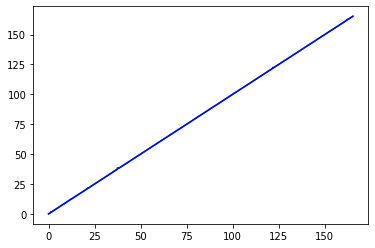

In [15]:
results['TIMING_client_request_timestamp_zerobased'] = results["TIMING_client_request_timestamp"] - \
                                                        results["TIMING_client_request_timestamp"].iloc[0]
results['TIMING_model_response_timestamp_zerobased'] = results["TIMING_model_response_timestamp"] - \
                                                        results["TIMING_client_request_timestamp"].iloc[0]

plt.plot(results["TIMING_client_request_timestamp_zerobased"], results["TIMING_client_request_timestamp_zerobased"], 'g',
        results["TIMING_client_request_timestamp_zerobased"], results["TIMING_model_response_timestamp_zerobased"], 'b')
plt.show()

1421
0.05277965120829636
0.04586617592002211
1.0300407409667969
0.013922452926635742


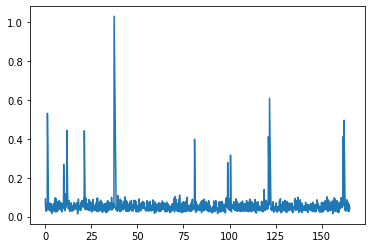

In [16]:
delta_t = results["TIMING_model_response_timestamp"].sub(results["TIMING_client_request_timestamp"])
print(len(delta_t))
print(delta_t.mean())
print(delta_t.std())
print(delta_t.max())
print(delta_t.min())

plt.plot(results["TIMING_client_request_timestamp_zerobased"], delta_t)
plt.show()

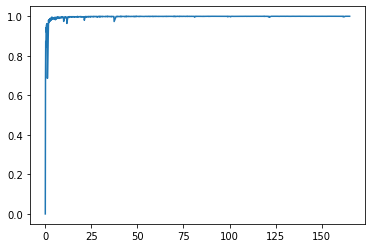

In [17]:
t_per_tau = results["TIMING_client_request_timestamp_zerobased"].divide(results["TIMING_model_response_timestamp_zerobased"])

plt.plot(results["TIMING_client_request_timestamp_zerobased"], t_per_tau)
plt.show()

In [18]:
len(results)

1421

Plot the simulation outputs

In [ ]:
plt.plot(results["time"], results["outputs[1]"], 'r',
         results["time"], results["outputs[2]"], 'b',
         results["time"], results["outputs[3]"],  'g',
         results["time"], results["outputs[4]"], 'y')
plt.show()

Plot the inputs

In [ ]:
plt.plot(results["time"], results["inputs"])

A log entry is written each time a ModelResponse object is received from the FMUModelHandler instance. Having a priori knowledge about how much the simulated time advances between two consecutive ModelResponses (in this case, approximately 0.001 seconds) allows to define the following:

t = simulated time elapsed since beginning of the experiment

tau = wall-clock time elapsed since beginning of the experiment

t/tau = real-time performance coefficient

Let's plot the t/tau metric for the current demo (slight preprocessing involved)

In [ ]:
results['timestamp'] = pd.to_datetime(results['timestamp'])

In [ ]:
results['elapsed_wallclock'] = pd.to_timedelta(results['timestamp']).dt.total_seconds() - \
pd.to_timedelta(results['timestamp']).dt.total_seconds().iloc[0]

In [ ]:
results.head()

In [ ]:
t_per_tau = results["time"].divide(results["elapsed_wallclock"])

In [ ]:
plt.plot(results["time"], t_per_tau)
plt.show()

## Discussion

Obviously the performance is very poor with the database operations as the bottleneck. Things could be improved substantially by introducing another means of accessing the input data, e.g., a TCP socket or similar.

See the original publication in [1] for further discussion